In [1]:
from brian2 import *
from brian2tools import *

import numpy as np
import pandas as pd
%matplotlib inline

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
dt = 0.01 * ms
defaultclock.dt = dt

# Generate a step-current input and an "experimental" voltage trace
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*5, np.zeros(int(5*ms/dt))])* 5 *nA
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*10, np.zeros(int(5*ms/dt))]) * 5 * nA

input_current = np.stack((input_current0, input_current1))
I = TimedArray(input_current0, dt=dt)

EL = -70*mV
VT = -50*mV
DeltaT = 2*mV

eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''')

group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group.v = -70 *mV
group.set_states({'gL': [30*nS], 'C':[1*nF]})

monitor0 = StateMonitor(group, 'v', record=True)
smonitor0  = SpikeMonitor(group)

In [3]:
run(60*ms)

In [4]:
voltage0 = monitor0.v[0]/mV
out_spikes0 = getattr(smonitor0, 't') / ms

start_scope()
I = TimedArray(input_current1, dt=dt)
group1 = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group1.v = -70 *mV
group1.set_states({'gL': [30*nS], 'C':[1*nF]})

monitor1 = StateMonitor(group1, 'v', record=True)
smonitor1  = SpikeMonitor(group1)

In [5]:
run(60*ms)

In [6]:
out_spikes1 = getattr(smonitor1, 't') / ms
voltage1 = monitor1.v[0]/mV

inp_trace0 = np.array([input_current0])
inp_trace1 = np.array([input_current1])

inp_traces = np.concatenate((inp_trace0, inp_trace1))
out_spikes = np.array([out_spikes0, out_spikes1])
print('inp_traces', inp_traces)
print('out_spikes', out_spikes)

inp_traces [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
out_spikes [array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ])
 array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])]


In [7]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [8]:
inp_trace = df_inp_traces.to_numpy()
inp_trace = inp_trace[:2, 1:]
inp_trace

out_trace = df_out_traces.to_numpy()
out_trace = out_trace[:2, 1:]
out_trace

array([[-63.54211145, -65.52491616, -62.90054542, ..., -81.5252667 ,
        -82.30107475, -82.04870895],
       [-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384]])

In [9]:
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
dt = 0.01*ms

In [10]:
# Model for modelfitting
model = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm=1*ufarad*cm**-2 * area, El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)


n_opt = NevergradOptimizer()
metric = MSEMetric()

# Model Fitting in Brian 2
## Google Summer of Code Project with INCF

<table><tr>
<td> <img src="./images/brian-logo.png"  width="500" height="500"/>
<td> <img src="./images/gsoc-logo.png"  width="500" height="500"/>
<td> <img src="./images/incf-logo.png"  width="500" height="500"/>
</tr></table>

### Aleksandra Teska

# Goal: Create a Brian Model Fitting toolbox that works with traces and spike trains 
- vectorization and model flexibility from brian
- modularity: 
    * multiple optimization methods (libraries)
    * multiple metrics 
    * custom callback function available
- find a good balance between flexible system (user can define whatever they want) and convenience (provide a few standard metrics)               

<img src='./images/fit_traces_example.png'  width="1500" height="900" align="center"/>

# Model Fitting: 

## Requires:
- an **optimization algorithm**

- a **metric**
    
### makes use of Brian parallelisation and flexibility 

In [11]:
n_opt = NevergradOptimizer()
metric = MSEMetric()

res, error = fit_traces(model=model, 
                        input_var='I', 
                        output_var='v',
                        input=inp_trace * amp,
                        output=out_trace * mV,
                        dt=dt,
                        optimizer=n_opt,
                        metric=metric,
                        n_rounds=1, n_samples=5,
                        gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                        g_na=[1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
                        g_kd=[1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
                        )

INFO       No numerical integration method specified for group 'neurons', using method 'exponential_euler' (took 0.24s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]


round 0 with error 0.49004453872858966
parameters: {'g_kd': 0.00013692521628727702, 'g_na': 5.70914400442673e-05, 'gl': 7.410340977940397e-08}


```
n_opt = SkoptOptimizer()
metric = GammaFactor()

res, error = fit_spikes(...)
```

... we want a **modular** implementation that can be easily extended

# Optimizer


**`n_opt = NevergradOptimizer()`**
```
metric = MSEMetric()

res, error = fit_traces(...)
```

# Optimizer

- gradient free methods - global methods
    * evolutionary algorithms
    * genetic algorithms 
    * bayesian optimization 
    * ...
- gradient based methods - local application

## Follows `ask()/tell()` interface

```
parameters = optimizer.ask()

errors = simulator.run(parameters)

optimizer.tell(parameters, errors)

results = optimizer.recommend()

```

### Libraries: Nevergrad, Scikit-Optimize, ...

## Nevergrad
#### offers an extensive collection of algorithms that do not require gradient computation 


<img src='./images/animation_gray_border.gif'  width="900" height="900" align="right"/>

#### Method examples:
- Differential evolution.
- Sequential quadratic programming.
- FastGA.
- Covariance matrix adaptation.
- Particle swarm optimization.
- ...

#### https://github.com/facebookresearch/nevergrad

In [12]:
from nevergrad.optimization import registry

print(len(registry.keys()))

100


In [13]:
print(sorted(registry.keys()))

['ASCMA2PDEthird', 'ASCMADEQRthird', 'ASCMADEthird', 'AlmostRotationInvariantDE', 'AlmostRotationInvariantDEAndBigPop', 'BO', 'BPRotationInvariantDE', 'CM', 'CMA', 'CMandAS', 'CMandAS2', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyRandomSearch', 'CauchyScrHammersleySearch', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'DoubleFastGAOptimisticNoisyDiscreteOnePlusOne', 'EDA', 'FastGADiscreteOnePlusOne', 'FastGANoisyDiscreteOnePlusOne', 'FastGAOptimisticNoisyDiscreteOnePlusOne', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'LBO', 'LHSSearch', 'LargeHaltonSearch', 'LargeHaltonSearchPlusMiddlePoint', 'LargeHammersleySearch', 'LargeHammersleySearchPlusMiddlePoint', 'LargeScrHaltonSearch', 'LargeScrHaltonSearchPlusMiddlePoint', 'LargeScrHammersleySearch', 'LargeScrHammersleySearchPlusMiddlePoint', 'LargerScaleRandomSearchPlusMiddlePoint', 'LhsDE', 'MEDA', 'MPCEDA', 'MicroCMA', 'MidQRBO', 'Milli

#### Example:
- pick method, specify budget..

In [14]:
NevergradOptimizer(method='PSO')

## Scikit-Optimize (skopt)

<img src='./images/skopt_example_1to3.png'  width="450" height="450" align="right"/>

- bayesian-optimization
- library to minimize (very) expensive and noisy black-box functions
- implements several methods for sequential model-based 
  optimization
- based no scikit-learn minimize function

https://github.com/scikit-optimize

PyData talk: 
https://www.youtube.com/watch?v=DGJTEBt0d-s

### Methods:
- Gaussian process-based minimization algorithms "GP"
- Sequential optimization using gradient boosted trees "GBRT"
- Sequential optimisation using decision trees "ET"
- Random forest regressor "RF"

or a custom made sklearn regressor!

#### Example:
- pick method, number of initial points, aquisition function...
- documentation: https://scikit-optimize.github.io/#skopt.Optimizer

In [15]:
SkoptOptimizer(method='GP')

## And Other...
abstract `class Optimizer` prepared for different back-end libraries!

User can plug in different optimization tool, as long as it follows``` ask() / tell``` interface

# Metric:


`n_opt = NevergradOptimizer()`

**`metric = MSEMetric()`**

`res, error = fit_traces(...)`

## Two implemeneted:

## Mean Square Error 
$$ MSE ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2} $$


In [16]:
MSEMetric()

## Two implemeneted:

## Gamma Factor

$$\Gamma = \left (\frac{2}{1-2\delta r_{exp}}\right) \left(\frac{N_{coinc} - 2\delta N_{exp}r_{exp}}{N_{exp} + N_{model}}\right)$$

- $ N_{coinc}$ - number of coincidences
- $ N_{exp} $ and $ N_{model}$- number of spikes in experimental and model spike trains
- $ r_{exp} $ - average firting rate in experimental train 
- $ 2 \delta N_{exp}r_{exp}$ - expected number of coincidences with a poission process

In [17]:
GammaFactor(delta=10*ms, dt=0.1*ms)

### Ongoing work:
- feature-based metrics (eFEL library)
- phase plane histogram
- adding weights to features

#### abstract `class Metric` prepared for different methods implementations!

# Brian usage
- simulations run in parallel 
- both **runtime** and **standalone** modes avaliable, called in the same way as in regular brian script

`n_opt = NevergradOptimizer()`

`metric = MSEMetric()`

**`res, error = fit_traces(...)`**

## Additional Features

- callback 
- param_init
- method specification 
- offline MSE metric

### Callback:
boolean or function

```callback = True ``` - returns default print out

In [18]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

#### Goal: add tolerance, break loop if necessary

### param_init:

dictionary with initial values

In [19]:
param_init={'v': -65*mV}

### metric:

offline MSE calculation

metric = None

## Final Version:

In [20]:
n_opt = NevergradOptimizer()
metric = MSEMetric()

res, error = fit_traces(model=model, 
                        input_var='I', 
                        output_var='v',
                        input=inp_trace * amp,
                        output=out_trace * mV,
                        param_init={'v': -65*mV},
                        method='exponential_euler',
                        dt=dt,
                        optimizer=n_opt,
                        metric=metric,
                        callback=True,
                        n_rounds=1, n_samples=5,
                        gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                        g_na=[1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
                        g_kd=[1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
                        )

round 0 with error 0.35773045472557513
parameters: {'g_kd': 4.710246470905579e-05, 'g_na': 6.807918669324726e-05, 'gl': 6.211848063090419e-08}


# Model Fitting examples:

## `fit_spikes()`

#### Load the Data

In [21]:
inp_traces

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
out_spikes

array([array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]),
       array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])], dtype=object)

#### Setup The Model

In [23]:
dt = 0.01 * ms
defaultclock.dt = dt

In [24]:
start_scope()
eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''',
    EL = -70*mV,
    VT = -50*mV,
    DeltaT = 2*mV,
    )   

#### Fit traces

In [25]:
n_opt = NevergradOptimizer('DE')
metric = GammaFactor(dt, 60*ms)


res, error = fit_spikes(model=eqs, input_var='I', dt=dt,
                        input=inp_traces * amp, output=out_spikes,
                        n_rounds=2, n_samples=30, optimizer=n_opt,
                        metric=metric,
                        threshold='v > -50*mV',
                        reset='v = -70*mV',
                        method='exponential_euler',
                        param_init={'v': -70*mV},
                        gL=[20*nS, 40*nS],
                        C = [0.5*nF, 1.5*nF])

round 0 with error 0.35344827586206906
parameters: {'gL': 2.4120085921319945e-08, 'C': 9.892356555459487e-10}
round 1 with error 1.1102230246251565e-16
parameters: {'gL': 2.572435365022884e-08, 'C': 1.0030892472852578e-09}


#### Visualize the results

In [26]:
start_scope()
fits = generate_fits(model=eqs,
                     params=res,
                     input=inp_traces * amp,
                     input_var='I',
                     output_var='v',
                     dt=dt,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     method='exponential_euler',
                     param_init={'v': -70*mV})


print('fits', fits)

fits [[-70.         -69.99999998 -69.99999995 ... -66.93023977 -66.9310268
  -66.93181364]
 [-70.         -69.99999998 -69.99999995 ... -68.46512313 -68.46551665
  -68.46591007]] mV


In [27]:
start_scope()
goal = generate_fits(model=eqs,
                     params={'gL': [30*nS], 'C':[1*nF]},
                     input=inp_traces * amp,
                     input_var='I',
                     output_var='v',
                     dt=dt,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     method='exponential_euler',
                     param_init={'v': -70*mV})


print('goal', goal)

goal [[-70.         -69.99999997 -69.99999995 ... -66.98700554 -66.98790918
  -66.98881255]
 [-70.         -69.99999997 -69.99999995 ... -67.20473715 -67.20557549
  -67.20641358]] mV


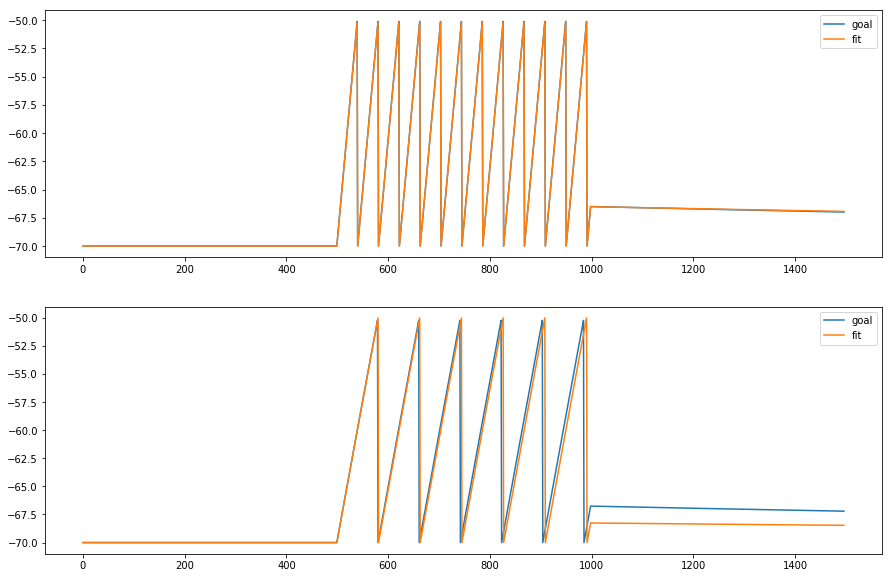

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax[0].plot(goal[0]/mV, label='goal');
ax[0].plot(fits[0]/mV, label='fit');
ax[1].plot(goal[1]/mV, label='goal');
ax[1].plot(fits[1]/mV, label='fit');
ax[0].legend()
ax[1].legend()
plt.show()

## `fit_traces()`

#### Load the Data

In [29]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [30]:
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[:4, 1:]
inp_traces

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e-09, 2.e-09, 2.e-09, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]])

In [31]:
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[:4, 1:]
out_traces

array([[-63.54211145, -65.52491616, -62.90054542, ..., -81.5252667 ,
        -82.30107475, -82.04870895],
       [-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384],
       [-62.92648395, -65.82540807, -64.76394825, ..., -64.9418292 ,
        -63.8704734 , -63.17105741],
       [-64.51645049, -66.84945425, -64.64260378, ..., -80.91299455,
        -79.08977935, -82.01562544]])

#### Setup Model

In [32]:
dt = 0.01 * ms
defaultclock.dt = dt

In [33]:
# Model for modelfitting
model = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
''',
El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)

#### Fit Traces

In [34]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
metric = MSEMetric()

res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=inp_traces * amp, output=out_traces*mV, dt=dt,
                        method='exponential_euler',
                        n_rounds=10, n_samples=30,
                        optimizer=n_opt, 
                        metric=metric,
                        callback=True,
                        Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                        gl = [1e-09 *siemens, 1e-07 *siemens],
                        g_na = [2e-06*siemens, 2e-04*siemens],
                        g_kd = [6e-07*siemens, 6e-05*siemens],
                        )

round 0 with error 0.9445711174634152
parameters: {'g_kd': 2.81192715863269e-05, 'Cm': 1.745343926442939e-10, 'g_na': 5.519791105634774e-05, 'gl': 4.5690445490669266e-08}
round 1 with error 0.900749486916749
parameters: {'g_kd': 2.318305064219119e-05, 'Cm': 1.9231510934940042e-10, 'g_na': 4.9489654475632326e-05, 'gl': 5.563515995147598e-08}
round 2 with error 0.8889643501376905
parameters: {'g_kd': 2.174338972158111e-05, 'Cm': 1.8058274182494597e-10, 'g_na': 5.370204156777897e-05, 'gl': 7.494271897402319e-08}
round 3 with error 0.917964414569195
parameters: {'g_kd': 2.174338972158111e-05, 'Cm': 1.8058274182494597e-10, 'g_na': 5.370204156777897e-05, 'gl': 7.494271897402319e-08}
round 4 with error 0.8706621060515259
parameters: {'g_kd': 1.7919379720203732e-05, 'Cm': 1.819212013103809e-10, 'g_na': 4.9979321357207795e-05, 'gl': 8.656277122069153e-08}
round 5 with error 0.8746153445280671
parameters: {'g_kd': 1.7919379720203732e-05, 'Cm': 1.819212013103809e-10, 'g_na': 4.9979321357207795e-0

#### Visualize the results

In [35]:
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=inp_traces * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v': -65*mV})

fits/mV

array([[-65.        , -65.        , -65.        , ..., -69.87024291,
        -69.84847608, -69.82680631],
       [-65.        , -65.        , -65.        , ..., -64.5029427 ,
        -64.50484236, -64.5067338 ],
       [-65.        , -64.89725777, -64.79497458, ..., -64.30786217,
        -64.31059722, -64.31332051],
       [-65.        , -65.        , -65.        , ..., -68.60572931,
        -68.58959697, -68.57353644]])

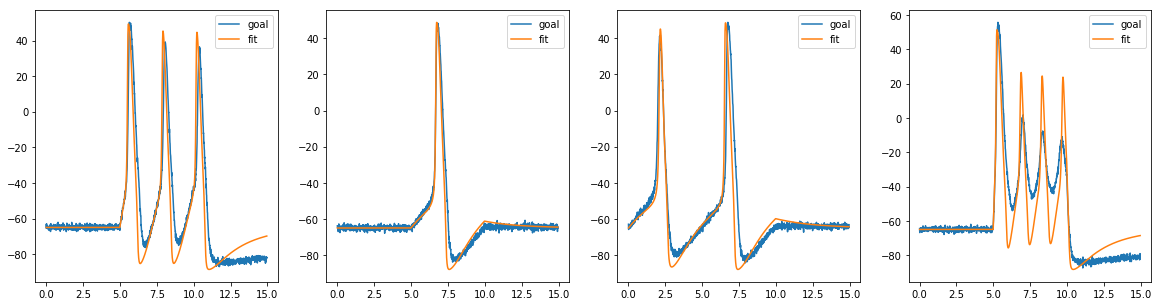

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0], label='goal');
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV, label='fit');
ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1], label='goal');
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV, label='fit');
ax[2].plot(np.arange(len(out_traces[2]))*dt/ms, out_traces[2], label='goal');
ax[2].plot(np.arange(len(fits[2]))*dt/ms, fits[2]/mV, label='fit');
ax[3].plot(np.arange(len(out_traces[3]))*dt/ms, out_traces[3], label='goal');
ax[3].plot(np.arange(len(fits[3]))*dt/ms, fits[3]/mV, label='fit');
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

# Ongoing work:

### Real Data Examples:
- 4 cells provided by Romain to be investigated


# Ongoing work:

### Local gradient calculation 

- method with use of local sensitivity

- already tested on simple problems
- can be used as a `polish = True` option: find exact minimum after global search - *hybird methods*

# Ongoing work:

## Other:
- documentation and debugging
- different callback functions
- different metrics

# Thank you for your attention!